In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import glob as gb 
import cv2
import os, random
import seaborn as sns
from keras.preprocessing import image
import sklearn
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from skimage import transform
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajakumarikothareddy","key":"3f09336c940a8ef0cb8ce5bf3e1406a1"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d puneet6060/intel-image-classification

 94% 325M/346M [00:01<00:00, 288MB/s]
100% 346M/346M [00:01<00:00, 249MB/s]


In [7]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [8]:
Sys_Name = tf.test.gpu_device_name()
Sys_Name

'/device:GPU:0'

In [9]:
print('Found GPU at: {}'. format(Sys_Name))

Found GPU at: /device:GPU:0


In [10]:
train_data_path = '/content/seg_train/seg_train'
test_data_path = '/content/seg_test/seg_test'
pred_data = '/content/seg_pred/seg_pred'

In [11]:
train_imagegenerator = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)

In [12]:
test_imagegenerator = ImageDataGenerator(rescale = 1./255)

In [13]:
Generated_Train_Data = train_imagegenerator.flow_from_directory(train_data_path,
                                                      target_size = (64,64),
                                                      class_mode = 'sparse',
                                                      shuffle = True,
                                                      batch_size=32)

Found 14034 images belonging to 6 classes.


In [14]:
Generated_Test_Data = test_imagegenerator.flow_from_directory(test_data_path, 
                                                    target_size = (64,64),
                                                    class_mode = 'sparse',
                                                    shuffle=False,
                                                    batch_size=32)

Found 3000 images belonging to 6 classes.


In [15]:
Label_Data = Generated_Train_Data.class_indices

In [16]:
Label_Data 

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [17]:
def Uploading_Training_Data(Source_MemoryPath):
  images_list = []
  names_list = []
  for name in os.listdir(Source_MemoryPath):
    File_Memory_Path = gb.glob(pathname = Source_MemoryPath+ '/'+ name+'/*.jpg')
    for p in File_Memory_Path:
      image = plot.imread(p)
      resized_images = cv2.resize(image,(64,64) )
      images_list.append(resized_images)
      names_list.append(Label_Data [name])
  return images_list, names_list

In [18]:
def x_pred(Source_Memory_Path):
  resizedimages = []
  for name in os.listdir(Source_Memory_Path):
    path_file = Source_Memory_Path+'/'+ name
    image = plot.imread(path_file)
    Resized_Images = cv2.resize(image,(64,64) )
    resizedimages.append(Resized_Images)
  return resizedimages

In [19]:
x_train_data, y_train_data = Uploading_Training_Data(train_data_path)
print('Length of Training set:', len(x_train_data), len(y_train_data))

Length of Training set: 14034 14034


In [20]:
x_pred_data =  x_pred(pred_data)

In [21]:
print('Length of Predicting set:', len(x_pred_data))

Length of Predicting set: 7301


In [22]:
from sklearn.utils import shuffle
x_train_data, y_train_data = sklearn.utils.shuffle(np.array(x_train_data), np.array(y_train_data), random_state = 42)

In [23]:
x_pred_data = np.array(x_pred_data)

In [24]:
def CNN_ModelAlgorithm():
  cnn = Sequential()
  cnn.add(Conv2D(32, (3,3), activation='relu', input_shape = (64,64,3)))
  cnn.add(MaxPooling2D(pool_size = (2,2)))
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  cnn.add(MaxPooling2D(pool_size = (2,2)))
  cnn.add(Conv2D(64, (3,3), activation = 'relu'))
  cnn.add(MaxPooling2D(pool_size = (2,2)))
  cnn.add(Flatten())
  cnn.add(Dense(32, activation = 'relu'))
  cnn.add(Dense(16, activation = 'relu'))
  cnn.add(Dense(6, activation = 'softmax'))
  return cnn

In [25]:
kfold = KFold(n_splits = 10, shuffle = True)

In [26]:
K_Fold_Accuracy = []
K_Fold_Loss = []
fold = 1

In [27]:
for Train_data, test in kfold.split(np.zeros(len(y_train_data)),y_train_data):
  Generated_Training_Data = train_imagegenerator.flow(x_train_data[Train_data], y_train_data[Train_data], batch_size=32)
  Value_Generated = test_imagegenerator.flow(x_train_data[test], y_train_data[test], batch_size=32)
  cnn = CNN_ModelAlgorithm()
  cnn.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])
  print ('-'*35, '\nTraining on fold {}'.format(fold))
  history = cnn.fit(Generated_Train_Data,  
                    epochs = 5,
                    validation_data=(Value_Generated) )
  
  Model_Scores = cnn.evaluate(Value_Generated, verbose=1)
  print(f"Score of fold: {fold}: {cnn.metrics_names[0]} is {Model_Scores[0]}, {cnn.metrics_names[1]} is {Model_Scores[1]}")
  
  K_Fold_Loss.append(Model_Scores[0])
  K_Fold_Accuracy.append(Model_Scores[1])
  fold += 1

----------------------------------- 
Training on fold 1
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


439/439 [==============================] - 38s 62ms/step - loss: 1.1929 - accuracy: 0.5311 - val_loss: 0.9813 - val_accuracy: 0.6204
Epoch 2/5
439/439 [==============================] - 26s 60ms/step - loss: 0.9355 - accuracy: 0.6397 - val_loss: 0.7983 - val_accuracy: 0.7137
Epoch 3/5
439/439 [==============================] - 26s 60ms/step - loss: 0.8318 - accuracy: 0.6901 - val_loss: 0.7518 - val_accuracy: 0.7215
Epoch 4/5
439/439 [==============================] - 27s 61ms/step - loss: 0.7493 - accuracy: 0.7227 - val_loss: 0.6443 - val_accuracy: 0.7642
Epoch 5/5
44/44 [==============================] - 0s 5ms/step - loss: 0.6786 - accuracy: 0.7557
Score of fold: 1: loss is 0.6786392331123352, accuracy is 0.755698025226593
----------------------------------- 
Training on fold 2
Epoch 1/5
439/439 [==============================] - 27s 61ms/step - loss: 1.1502 - accuracy: 0.5285 - val_loss: 1.0506 - val_accuracy: 0.5969
Epoch 2/5
439/439 [==============================] - 26s 60ms/step

In [28]:
print('Accuracy: ', np.mean(K_Fold_Accuracy))
print('Loss: ', np.mean(K_Fold_Loss))
print('Loss: ', np.mean(K_Fold_Loss))

Accuracy:  0.7786790251731872
Loss:  0.6102000117301941
Loss:  0.6102000117301941


In [29]:
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 6, 6, 64)        

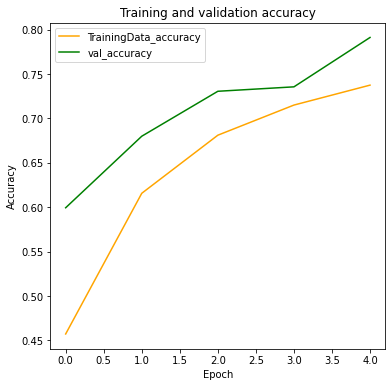

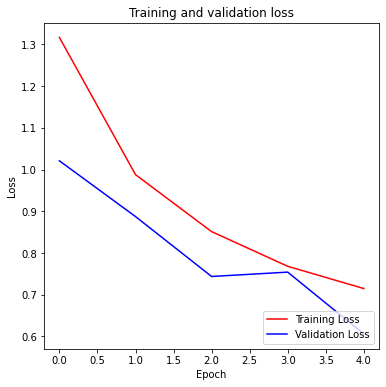

In [30]:
plot.figure(figsize=(6,6))
plot.plot(history.history['accuracy'],'orange', label = 'TrainingData_accuracy')
plot.plot(history.history['val_accuracy'], 'g', label = 'val_accuracy')
plot.xlabel('Epoch')
plot.ylabel('Accuracy')
plot.legend()
plot.title('Training and validation accuracy')
plot.show()

plot.figure(figsize=(6,6))
plot.plot( history.history['loss'], 'r', label='Training Loss')
plot.plot( history.history['val_loss'], 'b', label='Validation Loss')
plot.xlabel('Epoch')
plot.ylabel('Loss')
plot.title('Training and validation loss')
plot.legend()
plot.legend(loc = 'lower right')
plot.show()

In [31]:
cnn.fit(Generated_Train_Data, epochs = 5,  verbose = 1)

Epoch 1/5
439/439 [==============================] - 26s 60ms/step - loss: 0.6638 - accuracy: 0.7585
Epoch 2/5
439/439 [==============================] - 26s 60ms/step - loss: 0.6430 - accuracy: 0.7702
Epoch 3/5
439/439 [==============================] - 26s 60ms/step - loss: 0.6066 - accuracy: 0.7835
Epoch 4/5
439/439 [==============================] - 27s 60ms/step - loss: 0.5996 - accuracy: 0.7867
Epoch 5/5
439/439 [==============================] - 26s 59ms/step - loss: 0.5836 - accuracy: 0.7915


In [32]:
Model_Loss, Model_Accuracy = cnn.evaluate(Generated_Test_Data)

 3/94 [..............................] - ETA: 3s - loss: 0.8343 - accuracy: 0.6458 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


94/94 [==============================] - 3s 33ms/step - loss: 0.6005 - accuracy: 0.7913


In [33]:
print('Loss is: ', Model_Loss)
print('Accuracy is: ', Model_Accuracy)

Loss is:  0.6004661321640015
Accuracy is:  0.7913333177566528


In [34]:
Y_PredictingData = np.argmax(cnn.predict(Generated_Test_Data), axis=-1) 
y_true = Generated_Test_Data.classes

In [35]:
print(classification_report(y_true, Y_PredictingData, target_names=Label_Data))

              precision    recall  f1-score   support

   buildings       0.75      0.70      0.72       437
      forest       0.94      0.88      0.91       474
     glacier       0.85      0.69      0.76       553
    mountain       0.78      0.78      0.78       525
         sea       0.80      0.78      0.79       510
      street       0.69      0.92      0.79       501

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.80      0.79      0.79      3000



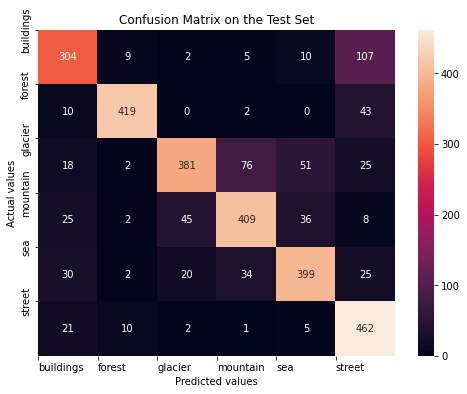

In [36]:
Error_Matrix = confusion_matrix(y_true, Y_PredictingData)
Label_Names = [k for k in Label_Data.keys()]
plot.figure(figsize=(8,6))
sns.heatmap(Error_Matrix, annot = True, fmt=".0f")
tick_marks = np.arange(len(Label_Names))
plot.xticks(tick_marks, Label_Names, horizontalalignment='left')
plot.yticks(tick_marks, Label_Names)
plot.xlabel ('Predicted values')
plot.ylabel ('Actual values')
plot.title('Confusion Matrix on the Test Set')
plot.show()

In [37]:
Predict_Data_Generator = ImageDataGenerator(rescale = 1./255)

In [38]:
Generated_Predict_Data = Predict_Data_Generator.flow(x_pred_data, batch_size=32, shuffle = False)

In [39]:
Y_Predict_Data = cnn.predict(Generated_Predict_Data, batch_size=32)

In [40]:
def Uploading_Images(path):
  file_path = random.choice(gb.glob(pathname = path+'/*.jpg'))
  img = image.load_img(file_path, target_size=(150, 150))
  np_image = np.array(img).astype('float32')/255
  np_image = transform.resize(np_image, (64, 64, 3))
  np_image_exp = np.expand_dims(np_image, axis=0)
  return img,np_image_exp

In [41]:
classes_decoded = dict([(v, k) for k, v in Label_Data.items()])

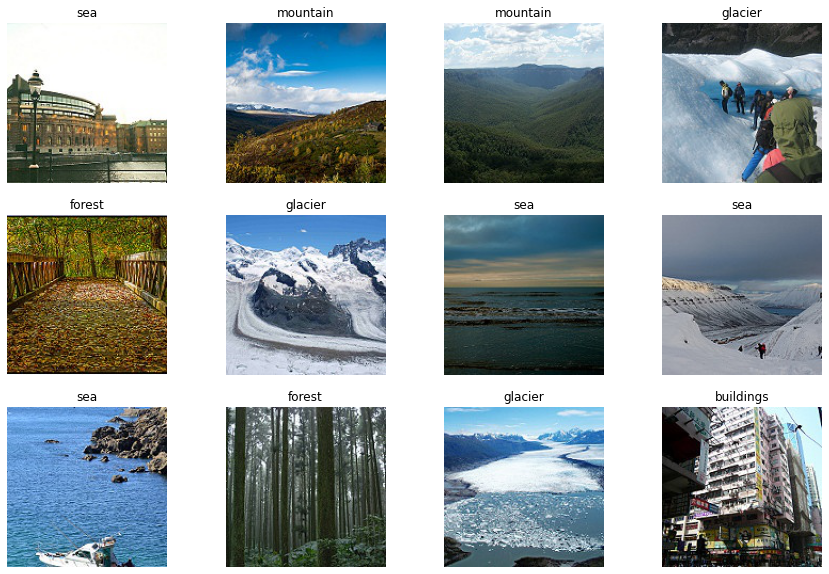

In [42]:
plot.figure(figsize=(15,10))
for i in range (12):
  ax = plot.subplot(3,4,i+1)
  img = Uploading_Images(pred_data)
  label=np.argmax(cnn.predict(img[1]), axis=-1)
  plot.title(classes_decoded[int(label)])
  plot.imshow(img[0])
  plot.axis("off")

In [43]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [44]:
Train_Data_ImageGenerator = ImageDataGenerator(rescale = 1./255,    
                                      shear_range = 0.2,
                                      rotation_range=20,
                                      zoom_range = 0.2,
                                      horizontal_flip = True,
                                      validation_split=0.2) 

In [45]:
Generated_Train_Data = Train_Data_ImageGenerator.flow_from_directory(train_data_path, 
                                     target_size = (150,150),
                                     class_mode = 'sparse',
                                     batch_size = 32, 
                                     shuffle=True,
                                     subset='training') 

Found 11230 images belonging to 6 classes.


In [46]:
Value_Generated = Train_Data_ImageGenerator.flow_from_directory(train_data_path, 
                                     target_size = (150,150),
                                     class_mode = 'sparse',
                                     batch_size = 32, 
                                     shuffle=True,
                                     subset='validation')


Found 2804 images belonging to 6 classes.


In [47]:
Test_Data_ImageGenerator = ImageDataGenerator(rescale=1./255)                           
Generated_TestingData = Test_Data_ImageGenerator.flow_from_directory(test_data_path, 
                                     target_size = (150,150),
                                     class_mode = 'sparse',
                                     shuffle = False)


Found 3000 images belonging to 6 classes.


In [48]:
Base_Conversion = ResNet50V2(input_shape=(150,150, 3), 
                     include_top=False, 
                     weights='imagenet')


94683136/94668760 [==============================] - 2s 0us/step


In [49]:
number_layers = 150
for layers in Base_Conversion.layers[:number_layers]:
    layers.trainable = False

In [50]:
Base_Conversion.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

In [51]:
print('The number of layers: ', len(Base_Conversion.layers))

The number of layers:  190


In [52]:
Best_Model = Base_Conversion

In [53]:
Best_Model = Best_Model.output
Best_Model = tf.keras.layers.GlobalMaxPooling2D()(Best_Model)
Best_Model = tf.keras.layers.Flatten(name="Flatten")(Best_Model)
Best_Model = tf.keras.layers.Dense(1024, activation='relu')(Best_Model)
Best_Model = tf.keras.layers.Dropout(0.2)(Best_Model)
prediction_layer = tf.keras.layers.Dense(6, activation='softmax')(Best_Model)
tf_model = tf.keras.Model(inputs=Base_Conversion.input, outputs=prediction_layer)
tf_model.compile(optimizer='adam', 
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = 'accuracy')

In [54]:
tf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

In [55]:
history = tf_model.fit(Generated_Train_Data, 
                     epochs = 5,
                     validation_data =Value_Generated,
                     batch_size = 32)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


351/351 [==============================] - 92s 243ms/step - loss: 0.7979 - accuracy: 0.8334 - val_loss: 33.7845 - val_accuracy: 0.7899
Epoch 2/5
351/351 [==============================] - 82s 235ms/step - loss: 0.3890 - accuracy: 0.8772 - val_loss: 0.3387 - val_accuracy: 0.8741
Epoch 3/5
351/351 [==============================] - 83s 237ms/step - loss: 0.3220 - accuracy: 0.8973 - val_loss: 0.3142 - val_accuracy: 0.8984
Epoch 4/5
351/351 [==============================] - 82s 232ms/step - loss: 0.2913 - accuracy: 0.9065 - val_loss: 0.2537 - val_accuracy: 0.9076
Epoch 5/5
351/351 [==============================] - 82s 235ms/step - loss: 0.3042 - accuracy: 0.9133 - val_loss: 0.3492 - val_accuracy: 0.8688


In [56]:
Model_Loss, Model_Accuracy = tf_model.evaluate(Generated_TestingData)

94/94 [==============================] - 6s 62ms/step - loss: 0.3429 - accuracy: 0.8707


In [57]:
print('Loss is: ', Model_Loss)
print('Accuracy is: ', Model_Accuracy)

Loss is:  0.3429020047187805
Accuracy is:  0.8706666827201843


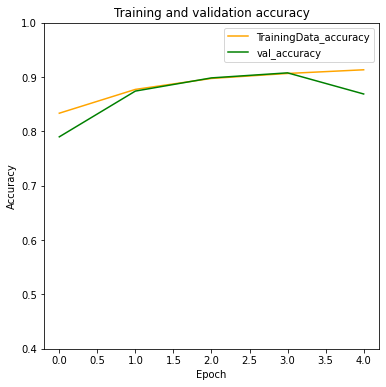

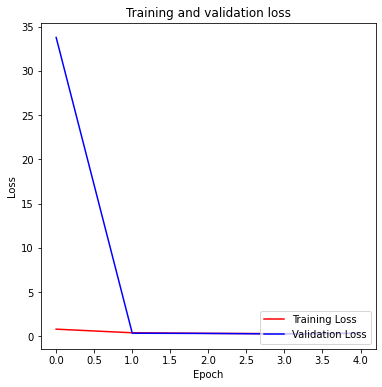

In [58]:
plot.figure(figsize=(6,6))
plot.plot(history.history['accuracy'],'orange', label = 'TrainingData_accuracy')
plot.plot(history.history['val_accuracy'], 'g', label = 'val_accuracy')
plot.xlabel('Epoch')
plot.ylabel('Accuracy')
plot.legend()
plot.ylim([0.4, 1])
plot.title('Training and validation accuracy')
plot.show()

plot.figure(figsize=(6,6))
plot.plot( history.history['loss'], 'r', label='Training Loss')
plot.plot( history.history['val_loss'], 'b', label='Validation Loss')
plot.xlabel('Epoch')
plot.ylabel('Loss')
plot.title('Training and validation loss')
plot.legend()
plot.legend(loc = 'lower right')
plot.show()

In [59]:
y_true = Generated_Test_Data.classes

In [60]:
label_names = Generated_Test_Data.class_indices

In [61]:
Y_PredictingData = np.argmax(tf_model.predict(Generated_Test_Data), axis=-1) 

In [62]:
print(classification_report(y_true, Y_PredictingData,  target_names=label_names))

              precision    recall  f1-score   support

   buildings       0.65      0.67      0.66       437
      forest       0.56      0.95      0.70       474
     glacier       0.81      0.13      0.23       553
    mountain       0.57      0.25      0.35       525
         sea       0.36      0.83      0.50       510
      street       0.82      0.40      0.54       501

    accuracy                           0.52      3000
   macro avg       0.63      0.54      0.50      3000
weighted avg       0.63      0.52      0.49      3000



In [63]:
def Uploading_Images(path):
  file_path = random.choice(gb.glob(pathname = path+'/*.jpg'))
  img = image.load_img(file_path, target_size=(150, 150))
  np_image = np.array(img).astype('float32')/255
  np_image_exp = np.expand_dims(np_image, axis=0)
  return img,np_image_exp

In [65]:
classes_decoded = dict([(v, k) for k, v in Generated_Test_Data.class_indices.items()])

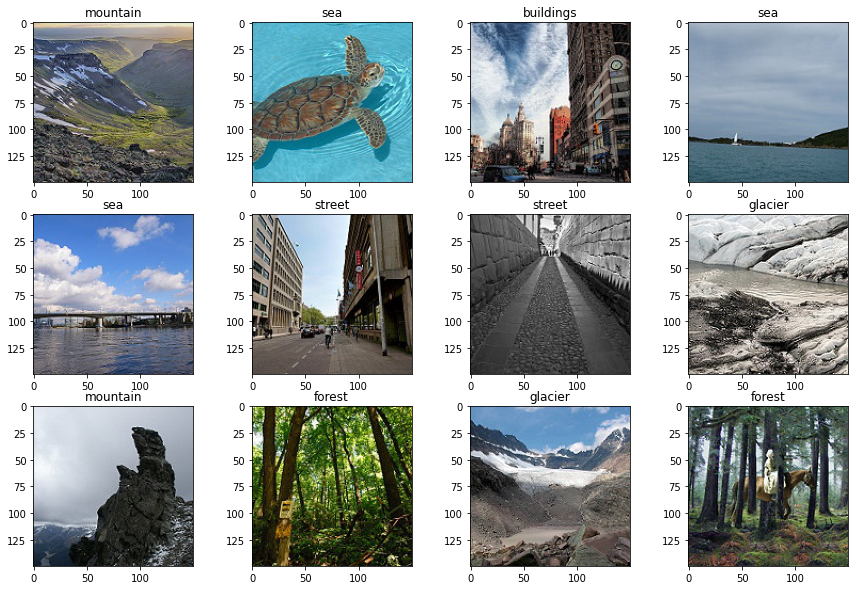

In [66]:
plot.figure(figsize=(15,10))
for i in range (12):
  ax = plot.subplot(3,4,i+1)
  img = Uploading_Images(pred_data)
  label=np.argmax(tf_model.predict(img[1]), axis=-1)
  plot.title(classes_decoded[int(label)])
  plot.imshow(img[0])

In [67]:
y_true = Generated_Test_Data.classes

In [68]:
label_names = Generated_Test_Data.class_indices

In [69]:
Y_PredictingData = np.argmax(tf_model.predict(Generated_Test_Data), axis=-1)

In [70]:
print(classification_report(y_true, Y_PredictingData, target_names=label_names))

              precision    recall  f1-score   support

   buildings       0.65      0.67      0.66       437
      forest       0.56      0.95      0.70       474
     glacier       0.81      0.13      0.23       553
    mountain       0.57      0.25      0.35       525
         sea       0.36      0.83      0.50       510
      street       0.82      0.40      0.54       501

    accuracy                           0.52      3000
   macro avg       0.63      0.54      0.50      3000
weighted avg       0.63      0.52      0.49      3000

